# Preliminaries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from scipy import stats

In [2]:
%matplotlib inline

Make plots much bigger

In [3]:
plt.rcParams['figure.figsize'] = [13.5, 9.]
plt.rcParams['font.size'] = 24

# Read All Data

In [4]:
data_tree_dir = ('../data_pickles')

In [5]:
basic_run_info = {}
run_info_keys = ['tf_seed', 'num_steps', 'num_initial_features', 'np_seed', 
                 'learning_algorithm', 'learning_rate', 'batch_size', 
                 'num_compressed_features', 'time']

learning_curve_info = {}
learning_curve_info_keys = ['step_numbers', 'loss_function_values']

matrices = {
    'tied_bias': {},
    'tied_no_bias': {},
    'untied': {},
    'fft_tied_no_bias': {}
}

for dir_name, subdirs, file_names in os.walk(data_tree_dir):
    for file_name in file_names:
        if '.pickle' in file_name:
            pathname = os.path.join(dir_name, file_name)
            with open(pathname, 'rb') as pickle_file:
                run_dict = pickle.load(pickle_file)
                basic_run_info[pathname] = {}
                learning_curve_info[pathname] = {}
                for key in run_info_keys:
                    if key in run_dict:
                        basic_run_info[pathname][key] = run_dict[key]
                for key in learning_curve_info_keys:
                    if key in run_dict:
                        learning_curve_info[pathname][key] = run_dict[key]
                if 'learning_rates' in dir_name:
                    continue
                for key in ['W', 'W1', 'W2', 'b1', 'b2']:
                    if key in run_dict:
                        dir_key = os.path.basename(dir_name)
                        if pathname in matrices[dir_key]:
                            matrices[dir_key][pathname] = {key: run_dict[key]}
                        else:
                            matrices[dir_key][pathname] = {key: run_dict[key]}

# Exploring All Parameters

## Constant Parameters

In [6]:
constant_parameters = {
    'tf_seed': 1,
    'np_seed': 1,
    'batch_size': 16,
    'num_initial_features': 784
}

for run_dict in basic_run_info.values():
    for key, value in constant_parameters.items():
        if run_dict[key] != value:
            print('Varied', key, run_dict[key])

## Non-Constant "Basic" Parameters + Wall Clock Time

In [7]:
[r for r in run_info_keys if r not in constant_parameters]

['num_steps',
 'learning_algorithm',
 'learning_rate',
 'num_compressed_features',
 'time']

## Learning Curves vs. Learning Rate, Adam

We plot learning curves for a linear autoencoder with tied weights, no bias terms, and num_compressed_features = 30 using Stochastic Gradient Descent with various learning rates and with Adam.

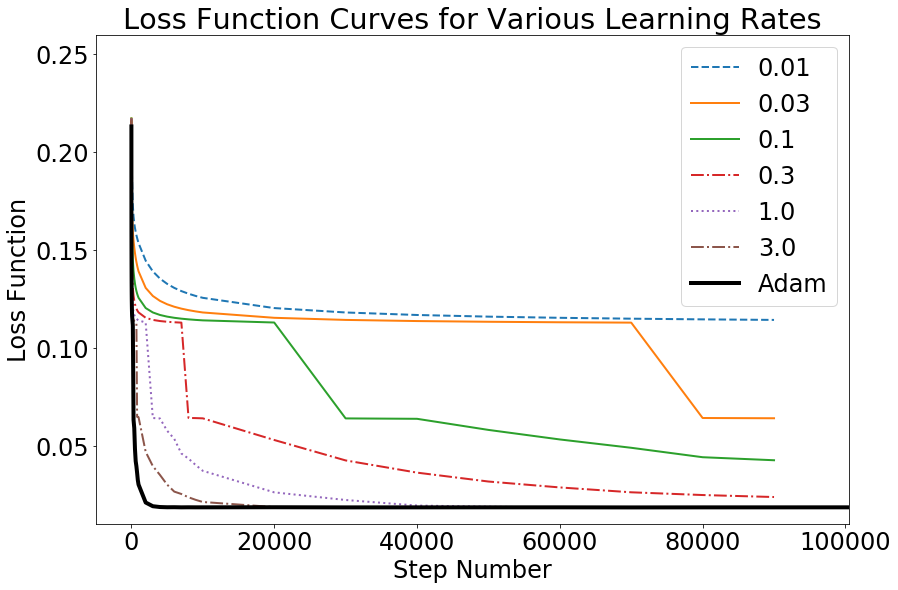

In [8]:
for i, ls in zip(range(1,7), ['--', '-', '-', '-.', ':', '-.', '-']):
    data_pickle = '../data_pickles/learning_rates/run-' + str(i) + '.pickle'
    plt.plot(learning_curve_info[data_pickle]['step_numbers'], 
         learning_curve_info[data_pickle]['loss_function_values'], 
             lw = 2, ls = ls, 
             label = str(basic_run_info[data_pickle]['learning_rate']))
plt.plot(learning_curve_info['../data_pickles/learning_rates/run-10.pickle']['step_numbers'],
        learning_curve_info['../data_pickles/learning_rates/run-10.pickle']['loss_function_values'],
        lw = 4, label = 'Adam', color = 'black')
    
plt.title('Loss Function Curves for Various Learning Rates')
plt.xlabel('Step Number')
plt.ylabel('Loss Function')

plt.axis([-5000, 100500, 0.01, 0.26])

plt.legend()

Since Adam optimization works well with a modest number of steps in this representative example, we will use it for all of our subsequent autoencoder training

Note: I also tried larger learning curves, but these blow up (as evidenced by 'nan' occuring in the learning curve).


In [9]:
for i in range(7,10):
    data_pickle = '../data_pickles/learning_rates/run-' + str(i) + '.pickle'
    print(learning_curve_info[data_pickle]['loss_function_values'], '\n')

[0.21712871, 1.3667531, 2433.7249, 9.016658e+13, inf, inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] 

[0.21712871, 109.07084, 2.7582405e+11, inf, inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] 

[0.21712871, 16700.168, 1.1858746e+20, inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] 



## Learning Curves for all the other data points

In [10]:
keys_from_arch_num_compressed = {}
for arch in ['tied_no_bias', 'tied_bias', 'untied', 'fft_tied_no_bias']:
    key_list = [key for key in matrices[arch] if 'learning_rate' not in key]
    keys_from_arch_num_compressed[arch] = {basic_run_info[key]['num_compressed_features']: 
                                           key for key in key_list}

In [11]:
def learning_curve_plot(arch, plot_number, plot_dir = 'plots', axis = None, 
                       curves_per_plot = 8):
    if arch == 'tied_no_bias':
        title = 'Tied Weights, No Bias Vector'
    elif arch == 'tied_bias':
        title = 'Tied Weights and Bias Vectors'
    else:
        title = 'Untied Weights and Bias Vectors'

    key_dict = keys_from_arch_num_compressed[arch]
    num_compressed_features = sorted(key_dict.keys())[
            curves_per_plot * plot_number: 
            curves_per_plot * (plot_number+1)]
    
    for i, num_compressed in enumerate(num_compressed_features):
        if i % 3 == 0:
            ls = '-'
        elif i % 3 == 1:
            ls = '-.'
        else:
            ls = ':'
        key = key_dict[num_compressed]
        steps = learning_curve_info[key]['step_numbers']
        loss  = learning_curve_info[key]['loss_function_values']
        plt.plot(steps, loss, label = str(num_compressed),
                lw = 3, ls = ls)
        plt.legend()
        plt.xlabel('Step [#]')
        plt.ylabel('Loss Function')
        plt.title('Learning Curves: ' + title)
        
        if axis:
            plt.axis(axis)
    
        plt.savefig(os.path.join(
            plot_dir, 'learning_curve_' + arch + '_' + str(plot_number) + '.png'))

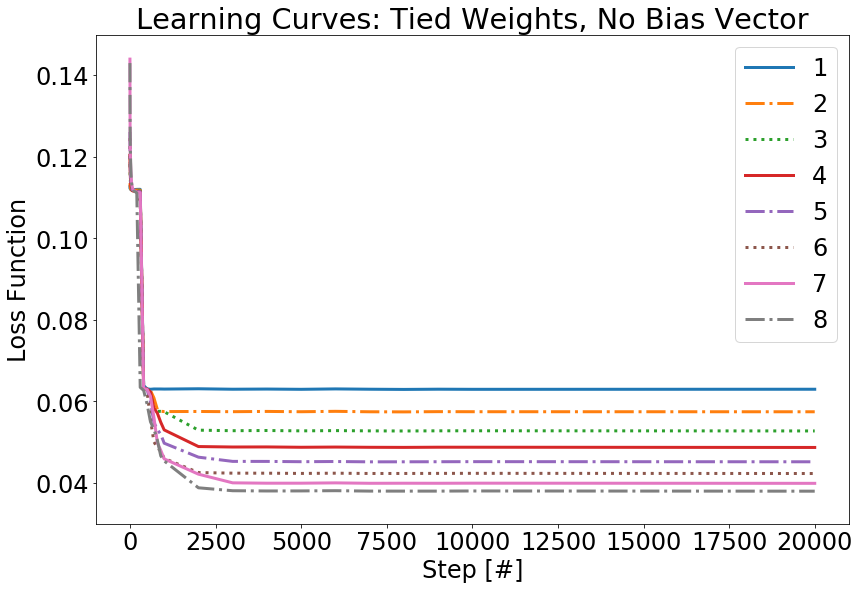

In [12]:
learning_curve_plot('tied_no_bias', 0, axis = [-1000, 21000, 0.03, 0.15])

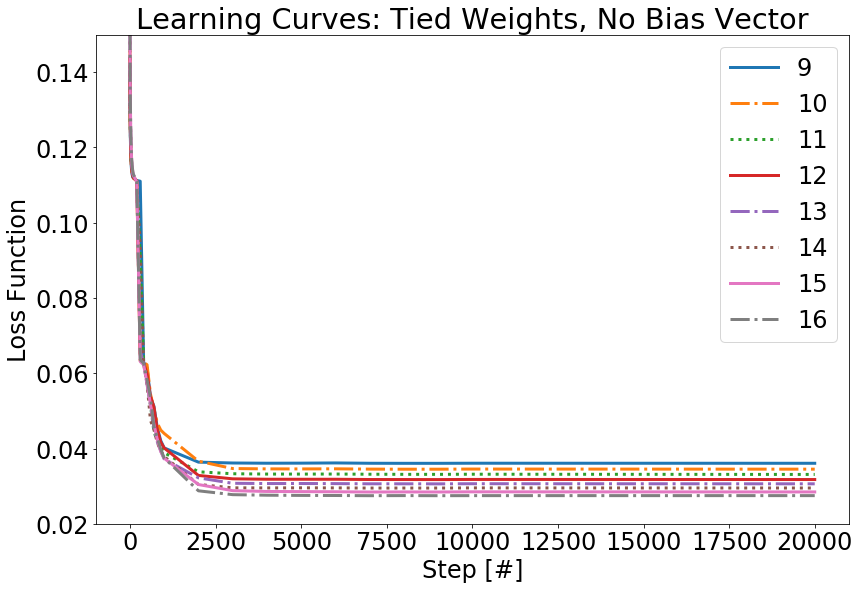

In [13]:
learning_curve_plot('tied_no_bias', 1, axis = [-1000, 21000, 0.02, 0.15])

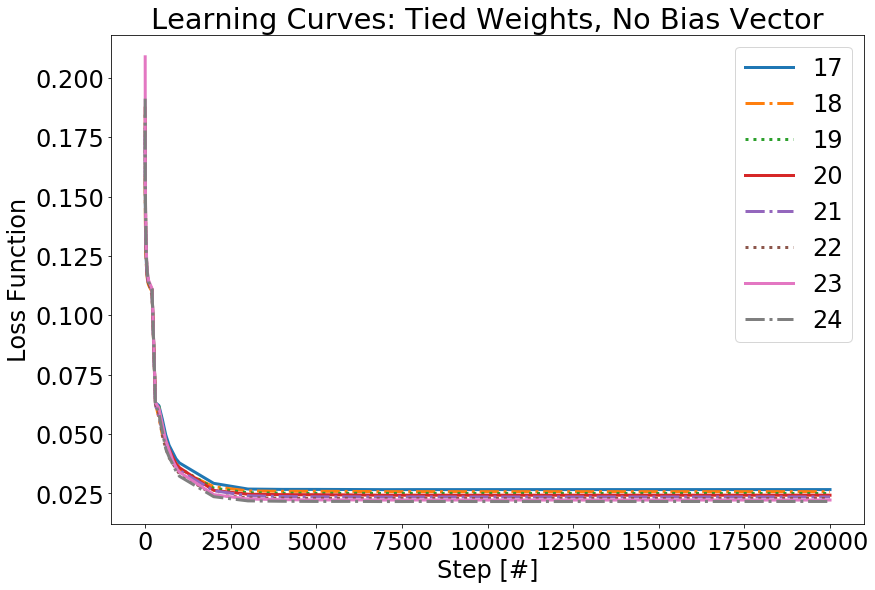

In [14]:
learning_curve_plot('tied_no_bias', 2)

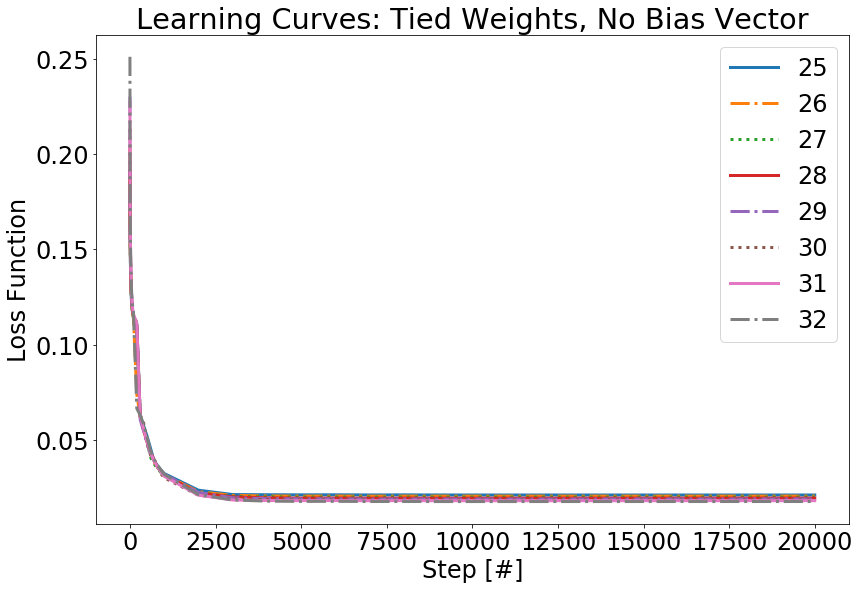

In [15]:
learning_curve_plot('tied_no_bias', 3)

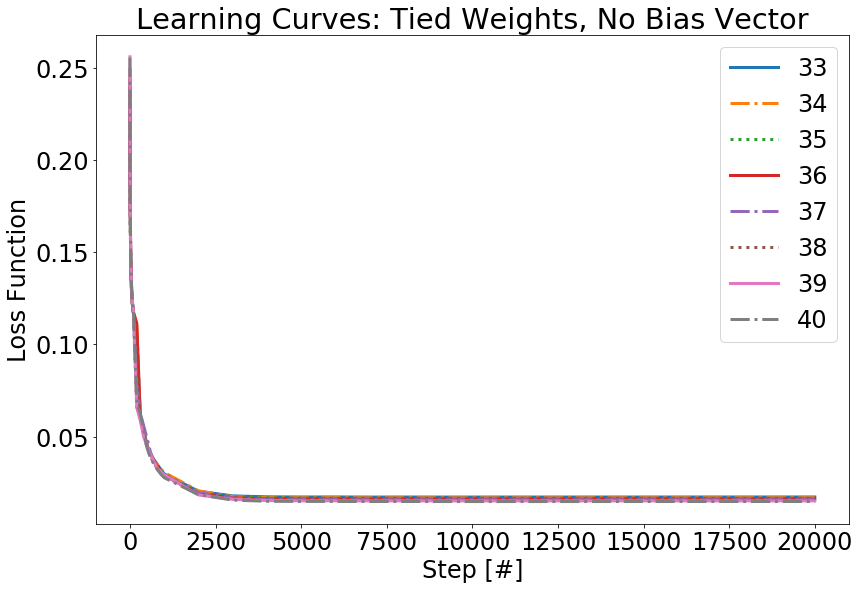

In [16]:
learning_curve_plot('tied_no_bias', 4)

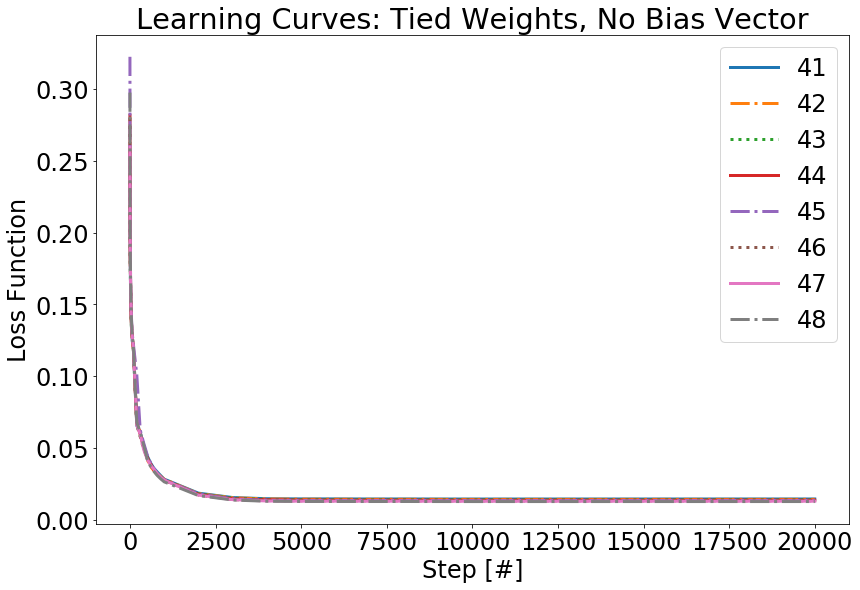

In [17]:
learning_curve_plot('tied_no_bias', 5)

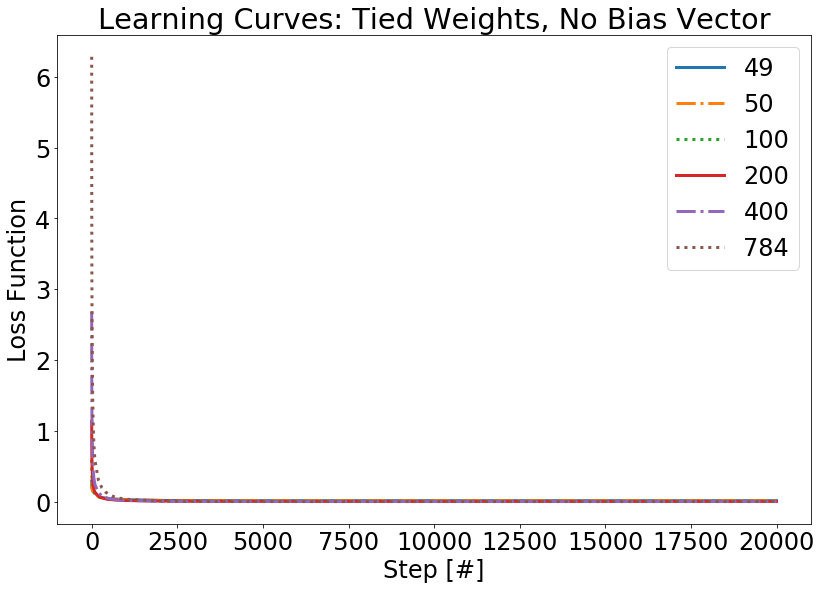

In [18]:
learning_curve_plot('tied_no_bias', 6)

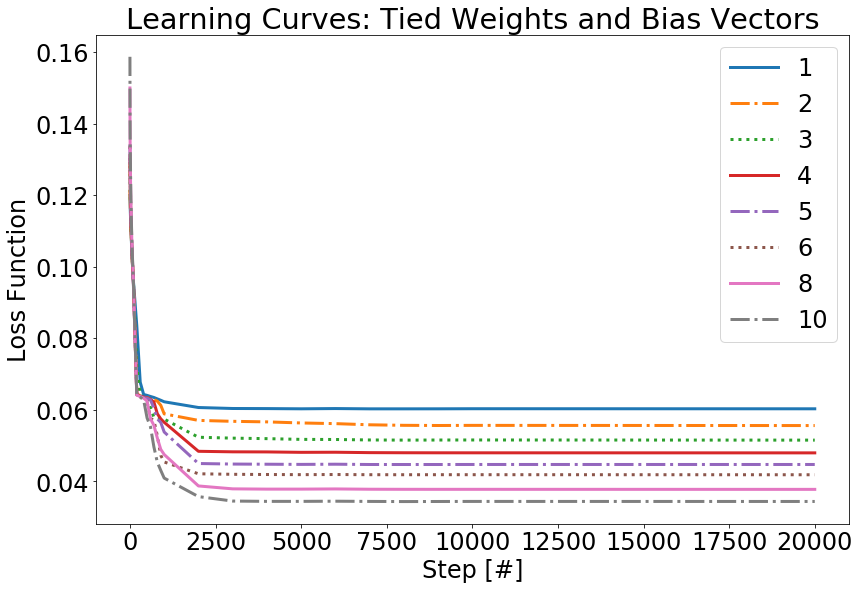

In [19]:
learning_curve_plot('tied_bias', 0)

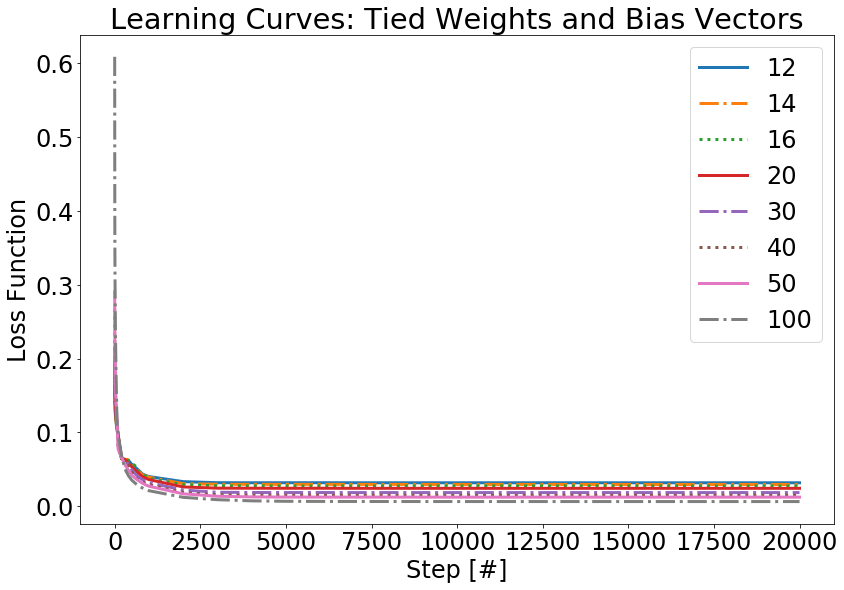

In [20]:
learning_curve_plot('tied_bias', 1)

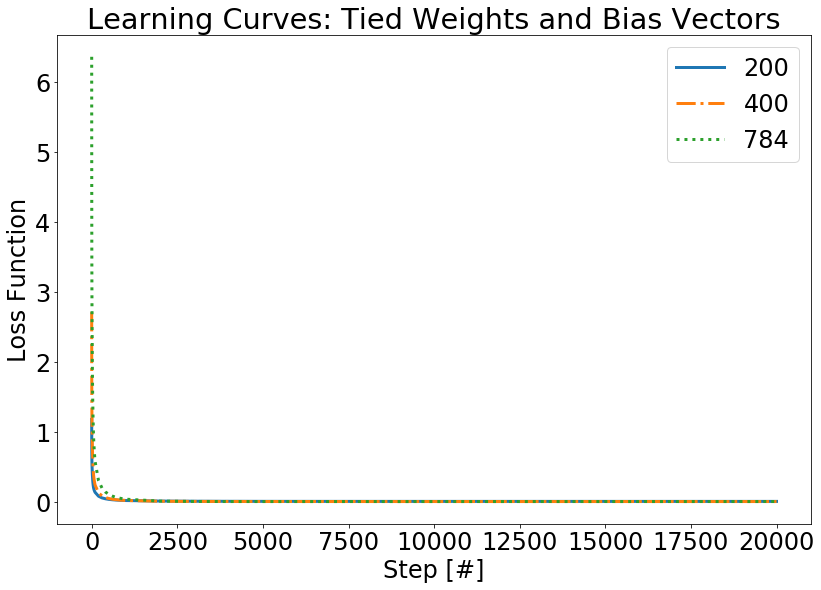

In [21]:
learning_curve_plot('tied_bias', 2)

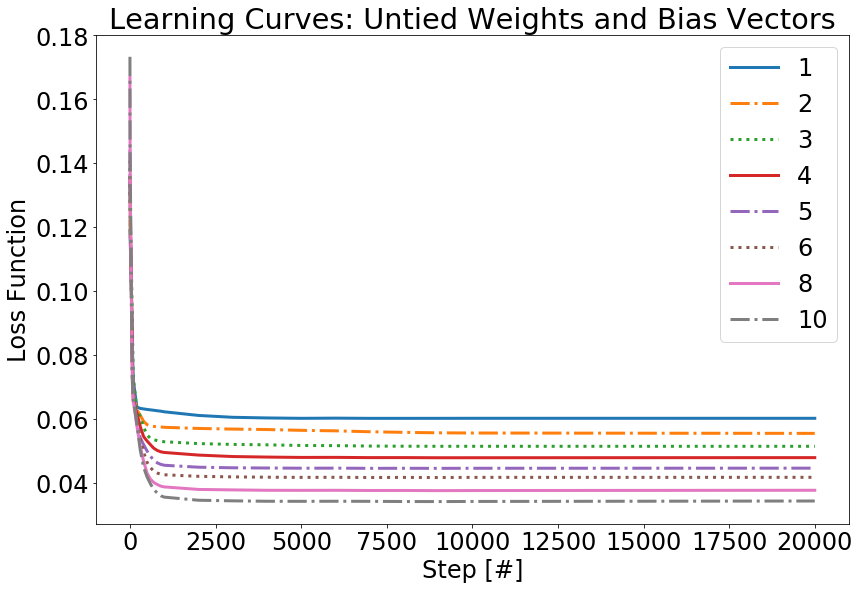

In [22]:
learning_curve_plot('untied', 0)

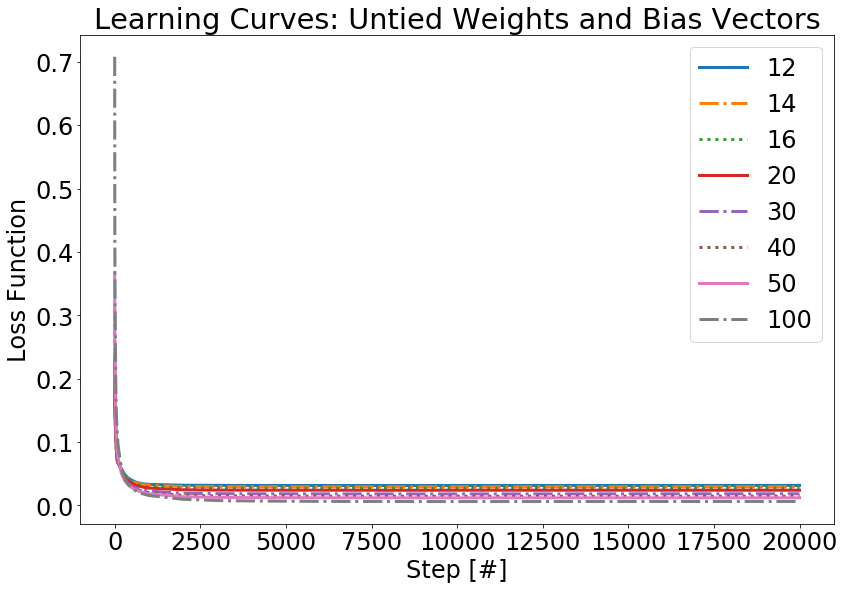

In [23]:
learning_curve_plot('untied', 1)

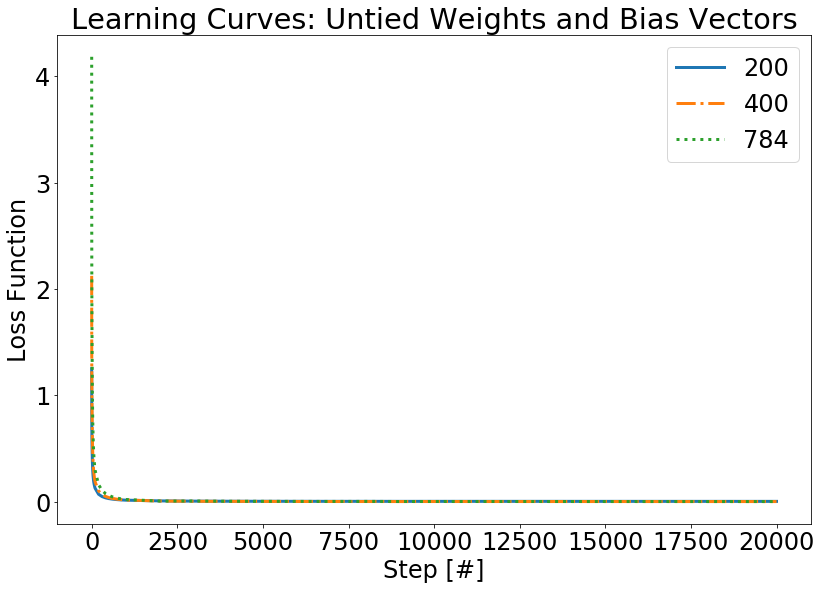

In [24]:
learning_curve_plot('untied', 2)

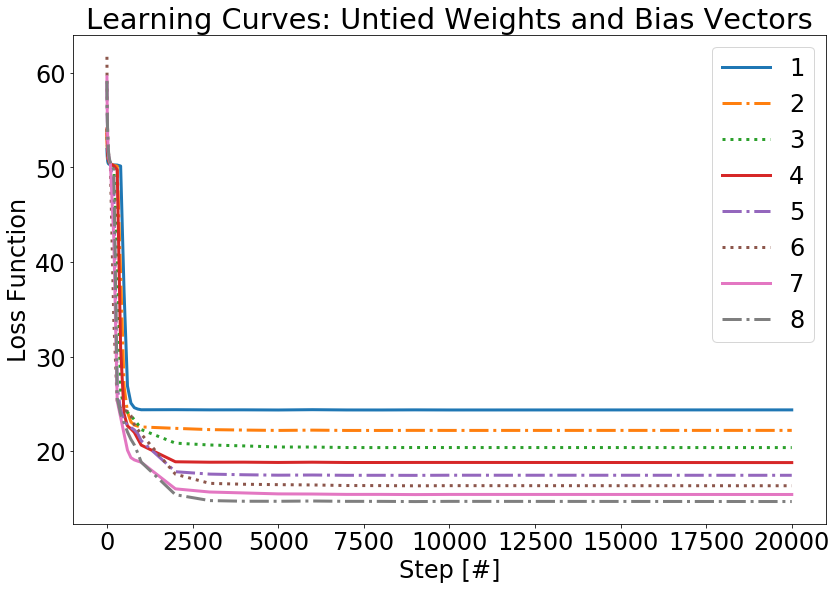

In [25]:
learning_curve_plot('fft_tied_no_bias', 0)

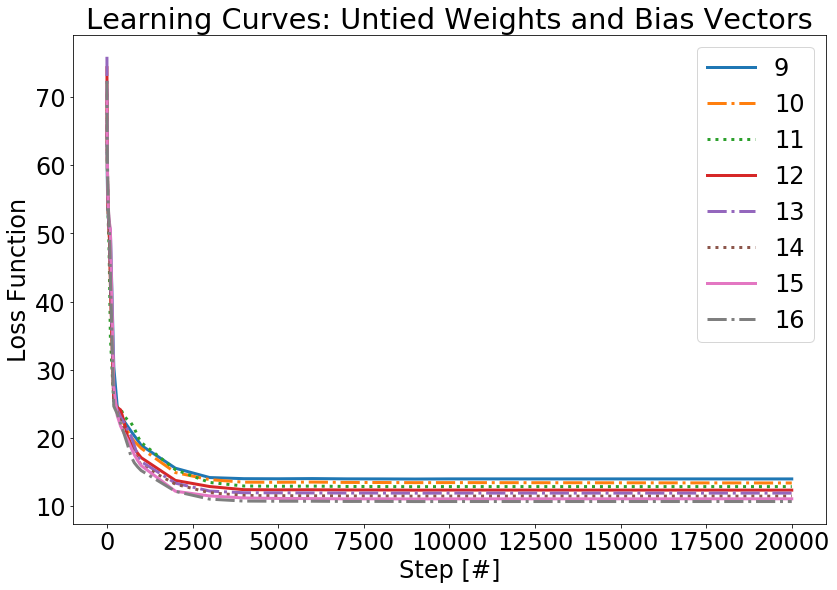

In [26]:
learning_curve_plot('fft_tied_no_bias', 1)

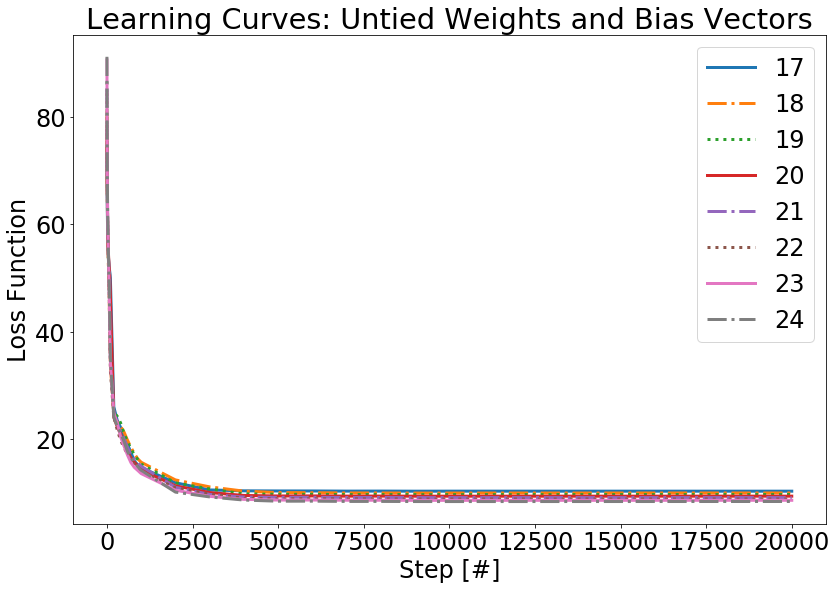

In [27]:
learning_curve_plot('fft_tied_no_bias', 2)

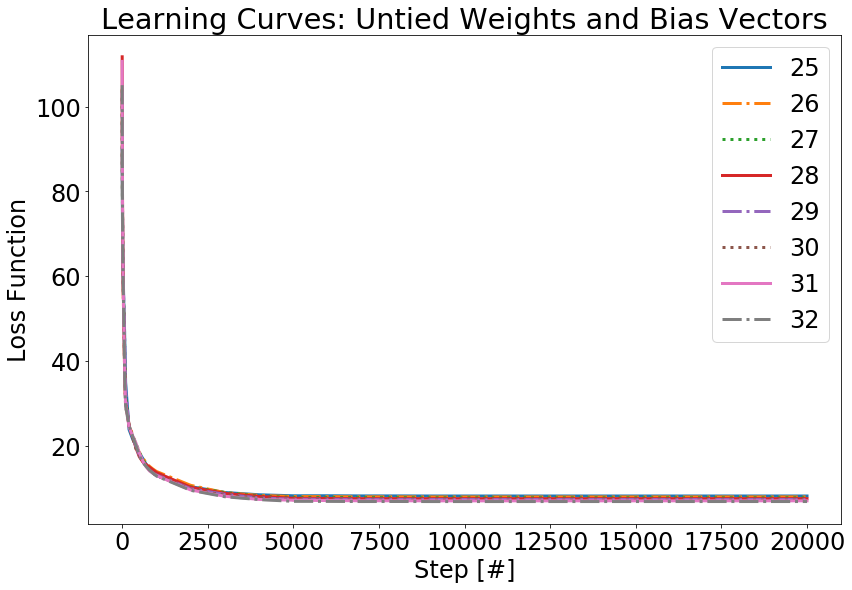

In [28]:
learning_curve_plot('fft_tied_no_bias', 3)

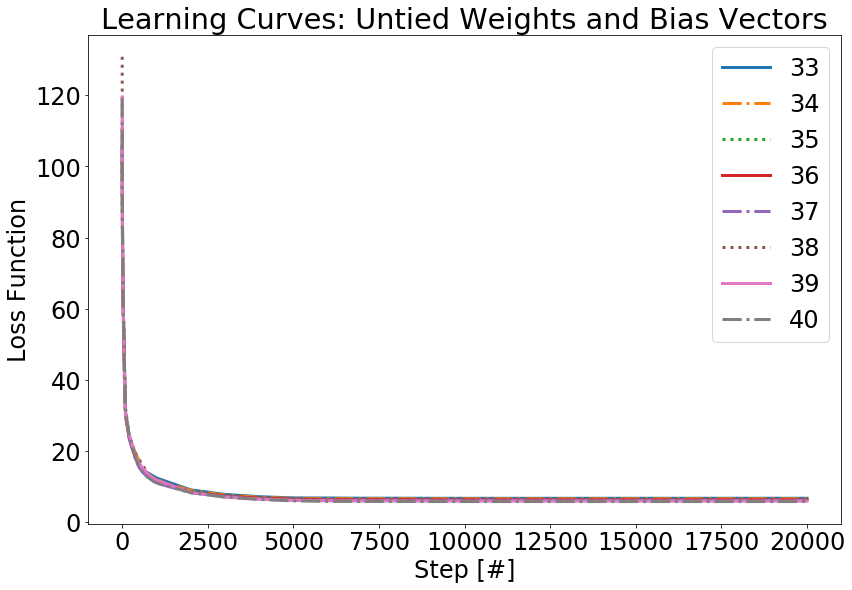

In [29]:
learning_curve_plot('fft_tied_no_bias', 4)

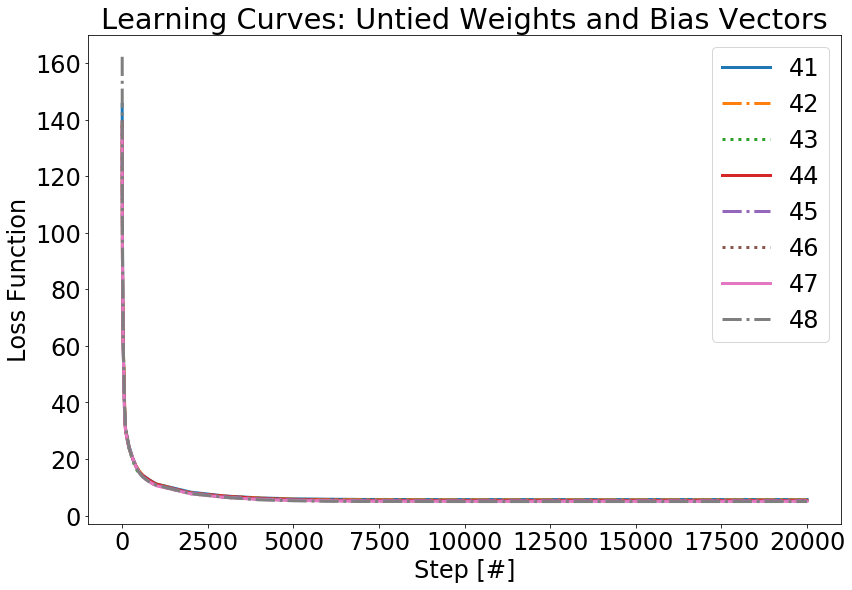

In [30]:
learning_curve_plot('fft_tied_no_bias', 5)

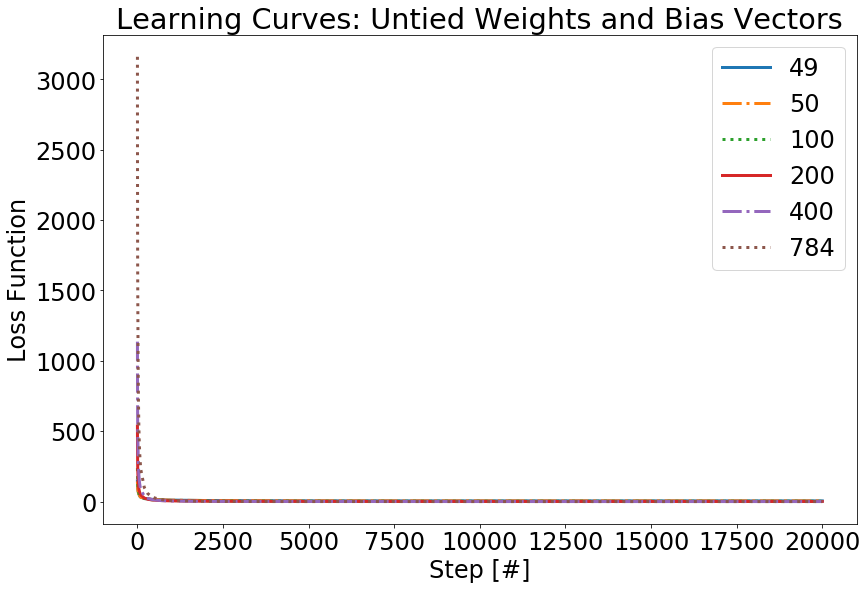

In [31]:
learning_curve_plot('fft_tied_no_bias', 6)

## Performance vs. num_compressed_features for the 3 algorithms

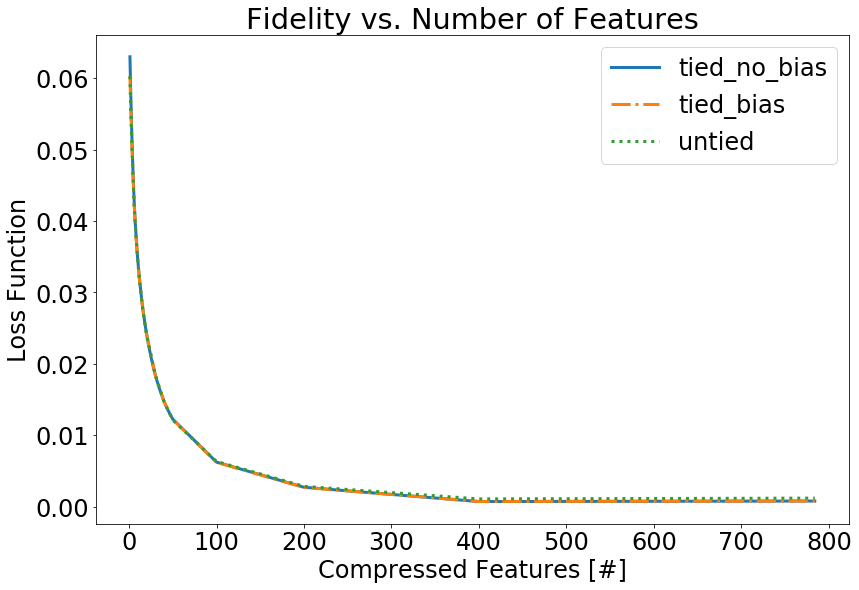

In [32]:
for arch, ls in zip(['tied_no_bias', 'tied_bias', 'untied'], 
                    ['-', '-.', ':']):

    n_list = sorted(keys_from_arch_num_compressed[arch].keys())
    key_list = [keys_from_arch_num_compressed[arch][n]
                for n in n_list]
    loss_list = [learning_curve_info[key]['loss_function_values'][-1]
                 for key in key_list]

    plt.plot(n_list, loss_list, label = arch, lw = 3, ls = ls)


plt.title('Fidelity vs. Number of Features')
plt.xlabel('Compressed Features [#]')
plt.ylabel('Loss Function')

plt.legend()

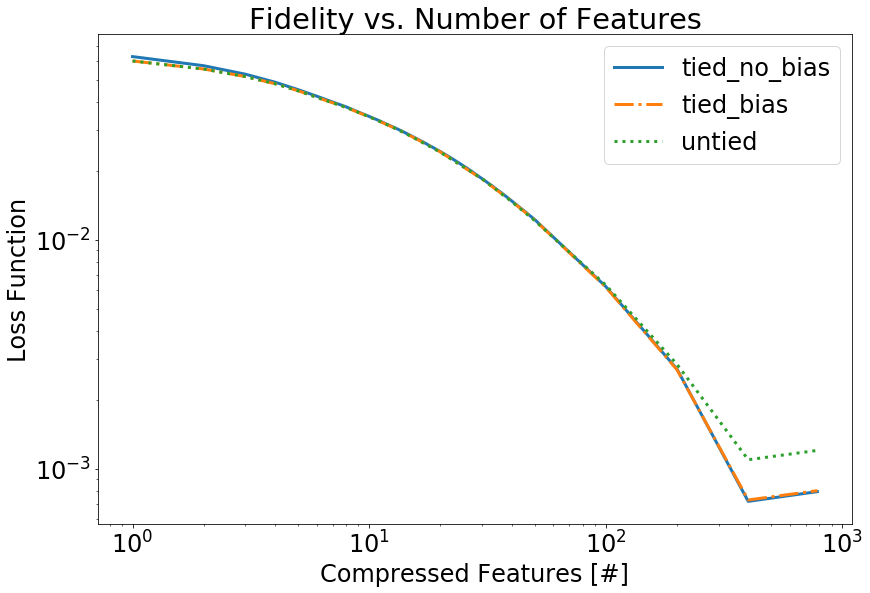

In [33]:
for arch, ls in zip(['tied_no_bias', 'tied_bias', 'untied'], 
                    ['-', '-.', ':']):

    n_list = sorted(keys_from_arch_num_compressed[arch].keys())
    key_list = [keys_from_arch_num_compressed[arch][n]
                for n in n_list]
    loss_list = [learning_curve_info[key]['loss_function_values'][-1]
                 for key in key_list]

    plt.plot(n_list, loss_list, label = arch, lw = 3, ls = ls)


plt.title('Fidelity vs. Number of Features')
plt.xlabel('Compressed Features [#]')
plt.ylabel('Loss Function')

plt.xscale('log')
plt.yscale('log')

plt.legend()